## Preprocess the data

In [4]:
# Imports

import os
import numpy as np
import cv2
from kaggle.api.kaggle_api_extended import KaggleApi

In [6]:
# Constants

IMG_SIZE = 50
BASE_PATH = 'kaggle_simpson_dataset/'
DATASET_PATH = 'dataset/'
TESTSET_PATH = 'testset/'
LABELS = os.listdir(DATASET_PATH)

### Download TestSet

In [22]:
if not (os.path.isdir(BASE_PATH)):
    from kaggle.api.kaggle_api_extended import KaggleApi
    
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files("alexattia/the-simpsons-characters-dataset")

In [23]:
!!unzip the-simpsons-characters-dataset.zip the-simpsons-characters-dataset

['Archive:  the-simpsons-characters-dataset.zip',
 'caution: filename not matched:  the-simpsons-characters-dataset']

### Load Dataset

In [26]:
# Load train images and LABELS Functions

def load_data():   
    train_images = []
    train_labels = []

    for label in LABELS:
        label_folder = os.path.join(DATASET_PATH, label)
        
        if len(os.listdir(label_folder)) < 100:
            print("[ERROR]: {} has only {} images".format(label, len(os.listdir(label_folder))))
            LABELS.remove(label)
            continue
        
        for _image in os.listdir(label_folder):
            _image_path = os.path.join(label_folder, _image)
            img = cv2.imread(_image_path, cv2.IMREAD_GRAYSCALE)
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
            
            train_images.append(np.array(img))
            train_labels.append(LABELS.index(label))
    
    return np.array(train_images, dtype=np.float64), np.array(train_labels)

In [27]:
# Load data

train_images, train_labels = load_data()
        
print(train_images.shape)
print(LABELS)

[ERROR]: patty_bouvier has only 72 images
[ERROR]: rainier_wolfcastle has only 45 images
[ERROR]: martin_prince has only 71 images
[ERROR]: fat_tony has only 27 images
[ERROR]: jasper_beardly has only 0 images
[ERROR]: carl_carlson has only 98 images
[ERROR]: snake_jailbird has only 55 images
[ERROR]: sideshow_mel has only 40 images
[ERROR]: helen_lovejoy has only 0 images
[ERROR]: jimbo_jones has only 0 images
[ERROR]: bumblebee_man has only 0 images
[ERROR]: hans_moleman has only 0 images
[ERROR]: troy_mcclure has only 8 images
[ERROR]: disco_stu has only 8 images
[ERROR]: agnes_skinner has only 42 images
(14120, 50, 50)
['maggie_simpson', 'charles_montgomery_burns', 'ralph_wiggum', 'chief_wiggum', 'milhouse_van_houten', 'cletus_spuckler', 'lenny_leonard', 'sideshow_bob', 'selma_bouvier', 'barney_gumble', 'gil', 'moe_szyslak', 'edna_krabappel', 'groundskeeper_willie', 'ned_flanders', 'abraham_grampa_simpson', 'krusty_the_clown', 'waylon_smithers', 'apu_nahasapeemapetilon', 'marge_sim

In [28]:
# Random Shuffle Train Images and LABELS (in unison)

s = np.random.permutation(len(train_labels))
np.random.shuffle(s)

train_images = train_images[s]
train_labels = train_labels[s]

### Test Loaded Dataset

In [29]:
import matplotlib.pyplot as plt

In [30]:
# Plot Image Function

def plot_img_label(img, label):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(img, cmap=plt.cm.binary)
    plt.xlabel(label)
    
def plot_img_colorbar(img):
    plt.imshow(img)
    plt.colorbar()
    plt.grid(False)


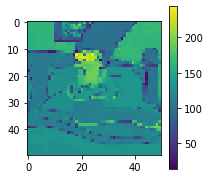

In [31]:
plt.figure(figsize = (3, 3))
plot_img_colorbar(train_images[0])
plt.show()

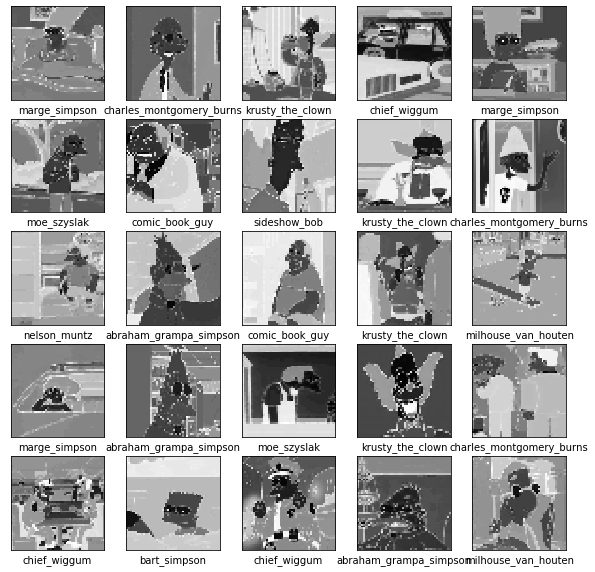

In [32]:
plt.figure(figsize = (10, 10))
for i in range(25):
    plot_img_label(train_images[i], LABELS[train_labels[i]])
plt.show()

### Load TestSet

In [33]:

def load_testset(path):
    test_images, test_labels = [], []
    
    for _file in os.listdir(path):
        
        # get label
        label = _file.split('.')[0].split('_')[:-1]
        label = '_'.join(label)
        
        # get image
        _image_path = os.path.join(path, _file)
        img = cv2.imread(_image_path, cv2.IMREAD_GRAYSCALE)
        try:
            img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
        except:
            print("Error while resizing image")
            continue
            
        if not label in LABELS:
            print("Error - label not found")
            continue

        test_images.append(np.array(img))
        test_labels.append(LABELS.index(label))
        
    return np.array(test_images, dtype=np.float64), np.array(test_labels)

In [34]:

test_images, test_labels = load_testset(TESTSET_PATH)

print(test_images.shape)

(990, 50, 50)


## Build the model

In [35]:
# TensorFlow and tf.keras
import tensorflow
from tensorflow import keras

In [36]:
model = keras.Sequential([
    keras.layers.BatchNormalization(axis=-1, momentum=0.99, epsilon=0.001, center=True, scale=True, beta_initializer='zeros', gamma_initializer='ones', moving_mean_initializer='zeros', moving_variance_initializer='ones', beta_regularizer=None, gamma_regularizer=None, beta_constraint=None, gamma_constraint=None),
    keras.layers.Flatten(input_shape=(IMG_SIZE, IMG_SIZE)),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(len(LABELS), activation='softmax')
])

In [37]:
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy'])

In [38]:
model.fit(train_images, train_labels, epochs=10)

Train on 14120 samples
Epoch 1/10
14120/14120 [==============================] - 2s 136us/sample - loss: 2.6509 - accuracy: 0.2613
Epoch 2/10
14120/14120 [==============================] - 2s 116us/sample - loss: 1.9438 - accuracy: 0.4188
Epoch 3/10
14120/14120 [==============================] - 2s 110us/sample - loss: 1.6072 - accuracy: 0.5202
Epoch 4/10
14120/14120 [==============================] - 2s 121us/sample - loss: 1.3695 - accuracy: 0.5982
Epoch 5/10
14120/14120 [==============================] - 2s 108us/sample - loss: 1.1553 - accuracy: 0.6563
Epoch 6/10
14120/14120 [==============================] - 1s 104us/sample - loss: 0.9817 - accuracy: 0.7101
Epoch 7/10
14120/14120 [==============================] - 1s 106us/sample - loss: 0.8227 - accuracy: 0.7599
Epoch 8/10
14120/14120 [==============================] - 1s 105us/sample - loss: 0.6804 - accuracy: 0.7989
Epoch 9/10
14120/14120 [==============================] - 1s 105us/sample - loss: 0.5875 - accuracy: 0.8280
Epoch

# Test the model

## Predict TestSet

In [39]:
predictions = model.predict(test_images)

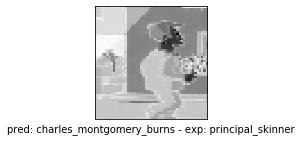

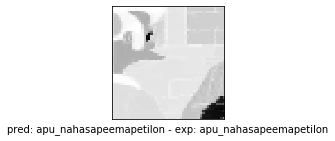

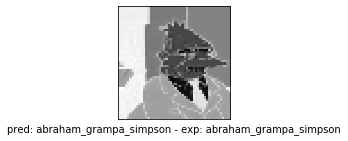

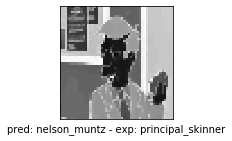

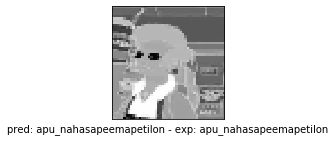

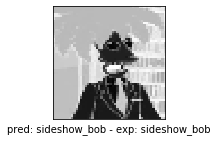

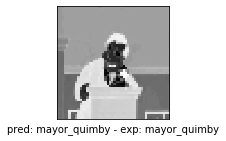

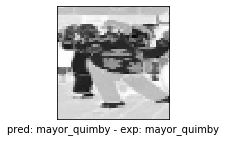

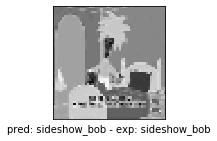

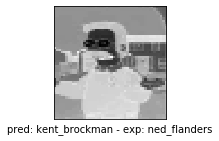

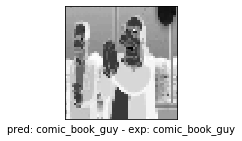

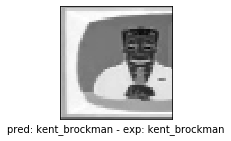

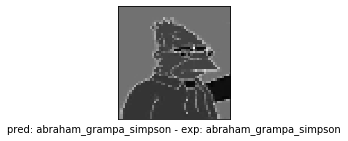

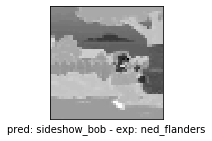

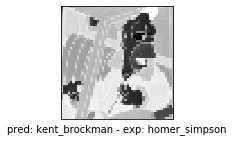

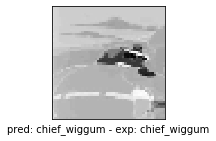

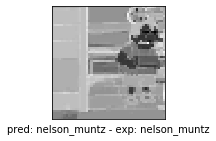

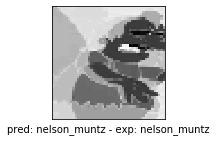

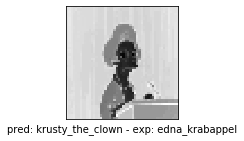

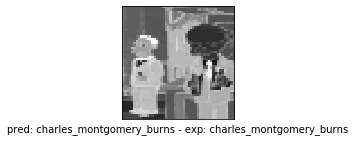

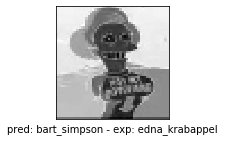

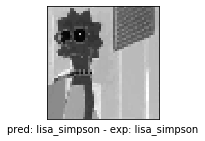

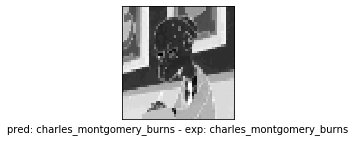

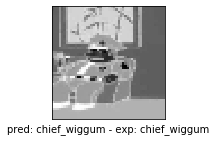

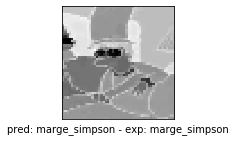

In [43]:

for i in range(25):
    pred = LABELS[np.argmax(predictions[i])]
    exp = LABELS[test_labels[i]]
    plt.figure(figsize=(12, 12))
    plot_img_label(test_images[i], "pred: {} - exp: {}".format(pred, exp))
    plt.show()

In [45]:
wrong = 0

for i in range(len(predictions)):
    pred = LABELS[np.argmax(predictions[i])]
    exp = LABELS[test_labels[i]]
    
    if pred != exp:
        wrong += 1

wir
print("Wrong predictions -> {}".format())

Wrong predictions -> 0.34040404040404043


## Plot Images With LABELS from TestSet

In [44]:
def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label, img = predictions_array, true_label[i], img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)